In [2]:
from numpy import where
from numpy import unique
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans,SpectralBiclustering,AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from xgboost import XGBClassifier
from sklearn import svm,tree,linear_model,ensemble,neighbors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style('white')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
pd.set_option('display.max_columns',None)


In [3]:
data_train = pd.read_csv('QUB_Insurance_Data_Assignment_Training.csv')
data_score = pd.read_csv('QUB_Insurance_Data_Assignment_Scoring.csv')


In [5]:
data1 = data_train.copy(deep=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              4090 non-null   int64  
 1   Title                   4090 non-null   object 
 2   GivenName               4090 non-null   object 
 3   MiddleInitial           4090 non-null   object 
 4   Surname                 4090 non-null   object 
 5   CreditCardType          3368 non-null   object 
 6   Occupation              2534 non-null   object 
 7   Gender                  4090 non-null   object 
 8   Age                     4090 non-null   int64  
 9   Location                4090 non-null   object 
 10  MotorInsurance          4090 non-null   object 
 11  MotorValue              3361 non-null   float64
 12  MotorType               3361 non-null   object 
 13  HealthInsurance         4090 non-null   object 
 14  HealthType              2543 non-null   

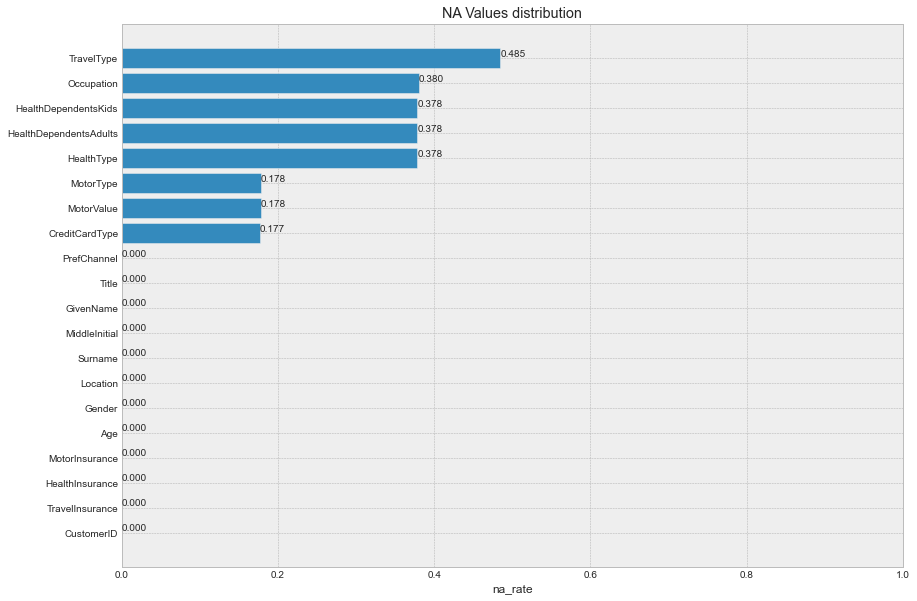

In [8]:
df=data1
na_rate = (len(df)-df.count())/len(df)
a = na_rate.sort_values()
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize=(14,10))
plt.barh(range(df.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.title('NA Values distribution')
plt.yticks(range(df.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f' %y,va='bottom')

In [13]:
data1.columns

Index(['CustomerID', 'Title', 'GivenName', 'MiddleInitial', 'Surname',
       'CreditCardType', 'Occupation', 'Gender', 'Age', 'Location',
       'MotorInsurance', 'MotorValue', 'MotorType', 'HealthInsurance',
       'HealthType', 'HealthDependentsAdults', 'HealthDependentsKids',
       'TravelInsurance', 'TravelType', 'PrefChannel'],
      dtype='object')

In [14]:
features_ordinal = ['CustomerID']
features_categorical = ['Title','CreditCardType','MotorType','HealthType','TravelType']
features_binary = ['Gender','Location', 'MotorInsurance','HealthInsurance','TravelInsurance']
features_numeric = ['Age', 'MotorValue','HealthDependentsAdults','HealthDependentsKids']
features_textual = ['GivenName', 'MiddleInitial', 'Surname', 'Occupation']

In [11]:
for feature in features_binary:
    print(feature)
    print(data1[feature].value_counts(dropna=False))
    

Gender
female    2063
male      2004
f           14
m            9
Name: Gender, dtype: int64
Location
Urban    2323
Rural    1767
Name: Location, dtype: int64
MotorInsurance
Yes    3361
No      729
Name: MotorInsurance, dtype: int64
HealthInsurance
Yes    2543
No     1547
Name: HealthInsurance, dtype: int64
TravelInsurance
Yes    2108
No     1982
Name: TravelInsurance, dtype: int64


In [16]:
for feature in features_categorical:
    print(feature)
    print(data1[feature].value_counts(dropna=True))

Title
Mr.     1950
Ms.     1064
Mrs.     949
Dr.      127
Name: Title, dtype: int64
CreditCardType
AMEX    1728
Visa    1640
Name: CreditCardType, dtype: int64
MotorType
Single    2287
Bundle    1074
Name: MotorType, dtype: int64
HealthType
Level2    1254
Level1     662
Level3     627
Name: HealthType, dtype: int64
TravelType
Business      669
Standard      477
Premium       442
Backpacker    336
Senior        184
Name: TravelType, dtype: int64


In [18]:
data1.loc[data1.MotorInsurance=='No','HealthType'].value_counts(dropna=False)


NaN       314
Level2    198
Level1    110
Level3    107
Name: HealthType, dtype: int64

In [20]:
data1.loc[data1.HealthInsurance=='No','HealthType'].value_counts()

Series([], Name: HealthType, dtype: int64)

In [22]:
data1.loc[data1.HealthInsurance=='Yes','HealthType'].value_counts()

Level2    1254
Level1     662
Level3     627
Name: HealthType, dtype: int64

In [25]:
data1.loc[data1.HealthInsurance=='No','HealthDependentsAdults'].value_counts(dropna=False)

NaN    1547
Name: HealthDependentsAdults, dtype: int64

In [27]:
data1.loc[data1.HealthInsurance=='Yes','HealthDependentsAdults'].value_counts(dropna=False)

1.00    1398
0.00     806
2.00     339
Name: HealthDependentsAdults, dtype: int64

In [29]:
data1.loc[data1.HealthInsurance=='No', 'HealthDependentsKids'].value_counts(dropna=False)
data1.loc[data1.HealthInsurance=='Yes', 'HealthDependentsAdults'].value_counts(dropna=False)

1.00    1398
0.00     806
2.00     339
Name: HealthDependentsAdults, dtype: int64

In [32]:
data1[features_numeric].count()

Age                       4090
MotorValue                3361
HealthDependentsAdults    2543
HealthDependentsKids      2543
dtype: int64

In [35]:
data1[features_numeric].describe()

Age  MotorValue  HealthDependentsAdults  HealthDependentsKids
count 4090.00     3361.00                 2543.00               2543.00
mean    41.39    23450.91                    0.82                  1.75
std     15.99    11985.63                    0.65                  1.11
min    -44.00   -25686.00                    0.00                  0.00
25%     22.00    14837.00                    0.00                  0.00
50%     46.00    25045.00                    1.00                  2.00
75%     50.00    32289.00                    1.00                  3.00
max    210.00   325940.00                    2.00                  3.00

<AxesSubplot:xlabel='Age'>

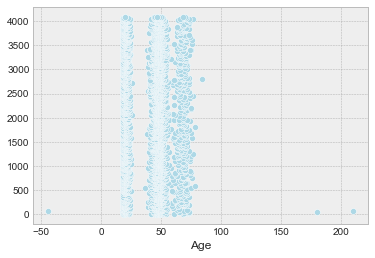

In [37]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
sns.scatterplot(x='Age',y=data1.index,data=data1,color='lightblue',ax=ax)

<AxesSubplot:xlabel='MotorValue'>

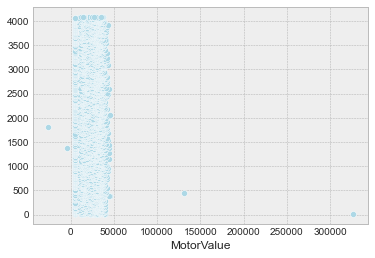

In [39]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
sns.scatterplot(x='MotorValue',y=data1.index,data=data1,color='lightblue',ax=ax)

<AxesSubplot:xlabel='MotorValue', ylabel='Density'>

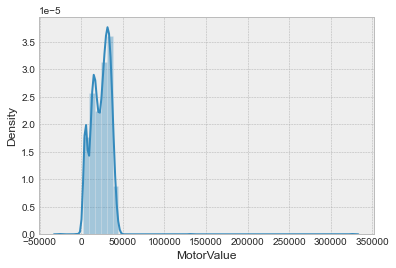

In [41]:
sns.distplot(data1.MotorValue)

In [47]:
data_cleaner = [data1,data_score]
for data in data_cleaner:
    data.Gender.replace('f','female',inplace=True)
    data.Gender.replace('m','male',inplace=True)
    if 'PrefChannel' in data.columns:
        data.PrefChannel.replace('P','Phone',inplace=True)
        data.PrefChannel.replace('E','Email',inplace=True)
        data.PrefChannel.replace('S','SMS',inplace=True)
    data.loc[(data.Age<=0)|(data.Age>=100),'Age']=data.Age.mean()
    data.loc[data.MotorValue<np.nanpercentile(data.MotorValue,1),'MotorValue']=int(np.nanpercentile(data.MotorValue,1))
    data.loc[data.MotorValue>np.nanpercentile(data.MotorValue,99),'MotorValue']=int(np.nanpercentile(data.MotorValue,1))


<AxesSubplot:xlabel='Age', ylabel='Density'>

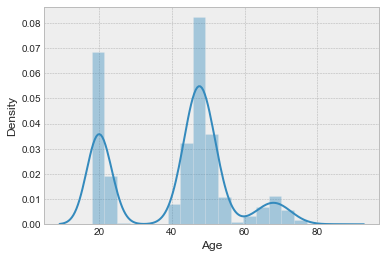

In [50]:
sns.distplot(data1.Age)

<AxesSubplot:xlabel='MotorValue', ylabel='Density'>

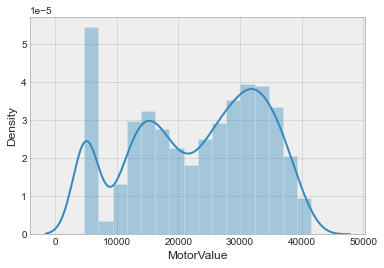

In [52]:
sns.distplot(data1.MotorValue)

In [53]:
for data in data_cleaner:
    data['AgeBin'] = pd.cut(data['Age'].astype(int),3)
    data['MotorValue_fillmean'] = data['MotorValue'].values
    data['MotorValue_fillmean'].fillna(data['MotorValue_fillmean'].mean(),inplace=True)
    data['MotorValue'].fillna(99999,inplace=True)
    data['MotorValueBin']= pd.cut(data['MotorValue'],[4683.137, 12092.6, 19465.2,26837.8,34210.4,1000000])

In [55]:
data1.Gender.value_counts()

female    2077
male      2013
Name: Gender, dtype: int64

In [56]:
for data in data_cleaner:
    data['CreditCardType'].fillna('NoData',inplace=True)
    data['MotorValue'].fillna('NoData',inplace=True)
    data['MotorType'].fillna('NoData',inplace=True)
    data['HealthType'].fillna('NoData',inplace=True)
    data['HealthDependentsAdults'].fillna('NoData',inplace=True)
    data['HealthDependentsKids'].fillna('NoData',inplace=True)
    data['TravelType'].fillna('NoData',inplace=True)
    

In [58]:
data1.HealthDependentsKids.value_counts()

NoData    1547
2.0       1203
3.0        674
0.0        648
1.0         18
Name: HealthDependentsKids, dtype: int64

In [59]:
for data in data_cleaner:
    data.loc[data.HealthDependentsKids==1,'HealthDependentsKids']=2
    

In [61]:
data1.HealthDependentsKids.value_counts()

NoData    1547
2.0       1221
3.0        674
0.0        648
Name: HealthDependentsKids, dtype: int64

In [63]:
data1.TravelType.value_counts()

NoData        1982
Business       669
Standard       477
Premium        442
Backpacker     336
Senior         184
Name: TravelType, dtype: int64

In [64]:
label = LabelEncoder()
data1['AgeBin_Code'] = label.fit_transform(data1['AgeBin'])
data1['Gender_Code'] = label.fit_transform(data1['Gender'])
data1['MotorInsurance_Code'] = label.fit_transform(data1['MotorInsurance'])
data1['HealthInsurance_Code'] = label.fit_transform(data1['HealthInsurance'])
data1['TravelInsurance_Code'] = label.fit_transform(data1['TravelInsurance'])


In [65]:
dummy_x = ['CreditCardType','HealthDependentsAdults',
           'HealthDependentsKids', 'Title', 'Gender',
           'Location', 'MotorValueBin',  
           'MotorType','HealthType', 'TravelType']
x = pd.get_dummies(data1[dummy_x])
data1_encoding = pd.concat([data1,x],axis=1)

In [66]:
label = LabelEncoder()

data_score['AgeBin_Code'] = label.fit_transform(data_score['AgeBin'])
data_score['Gender_Code'] = label.fit_transform(data_score['Gender'])

data_score['MotorInsurance_Code'] = label.fit_transform(data_score['MotorInsurance'])
data_score['HealthInsurance_Code'] = label.fit_transform(data_score['HealthInsurance'])
data_score['TravelInsurance_Code'] = label.fit_transform(data_score['TravelInsurance'])

dummy_x = ['CreditCardType','HealthDependentsAdults','HealthDependentsKids', 'Title', 'Gender', 'Location','MotorValueBin', 'MotorType','HealthType', 'TravelType']
x = pd.get_dummies(data_score[dummy_x])
data_score_encoding = pd.concat([data_score, x], axis=1)


In [70]:

for data in [data1_encoding,data_score_encoding]:
    data['MotorValueBin_1']= data['MotorValueBin_(4683.137, 12092.6]']
    data['MotorValueBin_2'] = data['MotorValueBin_(12092.6, 19465.2]']    
    data['MotorValueBin_3'] = data['MotorValueBin_(19465.2, 26837.8]']    
    data['MotorValueBin_4'] = data['MotorValueBin_(26837.8, 34210.4]']


In [72]:
data_x = [ 
 'Title_Dr.',
 'Title_Mr.',
 'Title_Mrs.',
 'Title_Ms.',
 'CreditCardType_AMEX',
 'CreditCardType_Visa',
 'Gender_female',
 'Gender_male',
 'AgeBin_Code',
 'Location_Rural',
 'Location_Urban',
 'MotorInsurance_Code',
 'HealthInsurance_Code',
 'TravelInsurance_Code',
 'MotorValueBin_1',
 'MotorValueBin_2',
 'MotorValueBin_3',
 'MotorValueBin_4',
 'MotorType_Bundle',
 'MotorType_Single',
 'HealthType_Level1',
 'HealthType_Level2',
 'HealthType_Level3',
 'HealthDependentsAdults_0.0',
 'HealthDependentsAdults_1.0',
 'HealthDependentsAdults_2.0',
 'HealthDependentsKids_0.0',
 'HealthDependentsKids_2.0',
 'HealthDependentsKids_3.0',
 'TravelType_Backpacker',
 'TravelType_Business',
 'TravelType_Premium',
 'TravelType_Senior',
 'TravelType_Standard'
]
len(data_x)

34

In [74]:
def correlation_headmap(df):
    _,ax=plt.subplots(figsize=(30,30))
    colormap = sns.diverging_palette(220,10,as_cmap=True)
    _ = sns.heatmap(df.corr(),
                    cmap=colormap,
                    square=True,
                    cbar_kws={'shrink':9},
                    ax=ax,
                    annot=True,
                    linewidths=0.1,vmax=1.0,linecolor='white',
                    annot_kws={'fontsize':12})
    plt.title('Pearson Corrletion of Features',y=1.05,size=15)
    

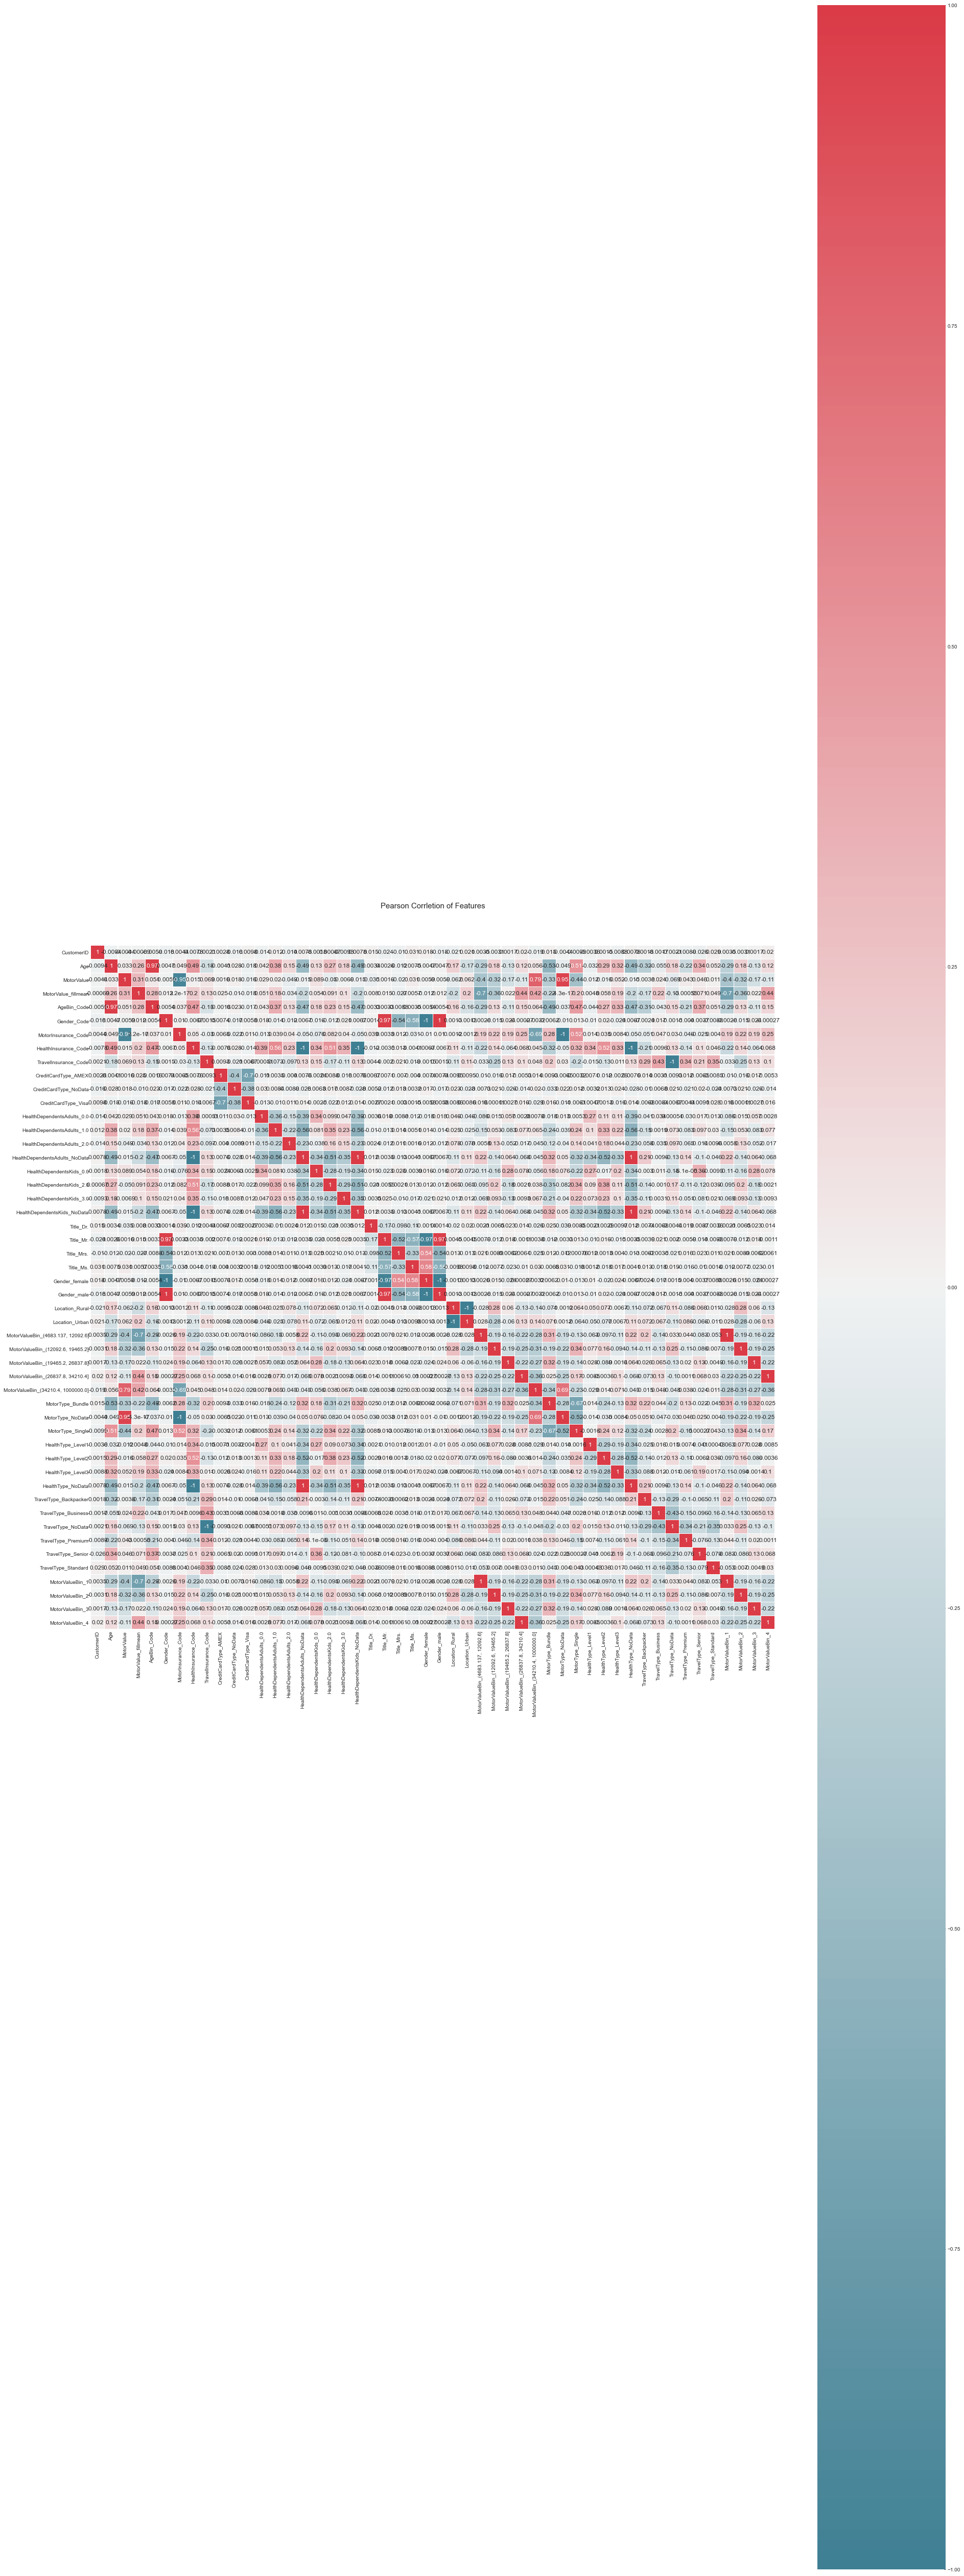

In [75]:
correlation_headmap(data1_encoding)

In [78]:
MLA = [
    svm.SVC(probability=True),
]

In [79]:
data_x = [
    'Title_Dr.',
    'Title_Mr.',
    'Title_Mrs.',
    'Title_Ms.',
    'CreditCardType_AMEX',
    'CreditCardType_Visa',
    #  'Gender_female',
    #  'Gender_male',
    'Gender_Code',
    'AgeBin_Code',
    'Location_Rural',
    'Location_Urban',
    'MotorInsurance_Code',
    #  'HealthInsurance_Code',
    #  'TravelInsurance_Code',

    'MotorValueBin_1',
    'MotorValueBin_2',
    'MotorValueBin_3',
    'MotorValueBin_4',

    #  'MotorType_Bundle',
    #  'MotorType_Single',
    #  'HealthType_Level1',
    #  'HealthType_Level2',
    #  'HealthType_Level3',
    'HealthDependentsAdults_0.0',
    'HealthDependentsAdults_1.0',
    'HealthDependentsAdults_2.0',
    'HealthDependentsKids_0.0',
    'HealthDependentsKids_2.0',
    'HealthDependentsKids_3.0',
    #  'TravelType_Backpacker',
    #  'TravelType_Business',
    #  'TravelType_Premium',
    #  'TravelType_Senior',
    #  'TravelType_Standard'
]

In [81]:
cv_split = model_selection.ShuffleSplit(n_splits=10,test_size=.3,train_size=.7,random_state=0)
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Test Accuracy Mean']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = pd.DataFrame()
MLA_predict['Target']=data1['PrefChannel'].copy(deep=True)

In [83]:
row_index = 0
for alg in MLA:
    MLA_name= alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name']=MLA_name
    MLA_compare.loc[row_index,'MLA Parameters']=str(alg.get_params())
    cv_results = model_selection.cross_validate(alg,data1_encoding[data_x],data1.PrefChannel,cv=cv_split)
    MLA_compare.loc[row_index,'MLA Test Accuracy Mean']=cv_results['test_score'].mean()
    alg.fit(data1_encoding[data_x],data1.PrefChannel)
    MLA_predict[str(MLA_name)]=alg.predict(data1_encoding[data_x])
    row_index +=1
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'],ascending=False,inplace=True)

In [85]:
MLA_compare

MLA Name                                     MLA Parameters  \
0      SVC  {'C': 1.0, 'break_ties': False, 'cache_size': ...   

  MLA Test Accuracy Mean  
0                   0.65

In [86]:
for alg in MLA:
    data_score_encoding['Predict'] = alg.predict(data_score_encoding[data_x])

In [88]:
data1_encoding.PrefChannel.value_counts()

Email    1768
Phone    1565
SMS       757
Name: PrefChannel, dtype: int64

Text(0, 0.5, 'Algorithm')

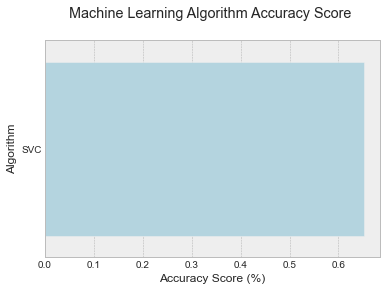

In [89]:
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name',
            data=MLA_compare, color='lightblue')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')


<AxesSubplot:xlabel='MLA Test Accuracy Mean', ylabel='MLA Name'>

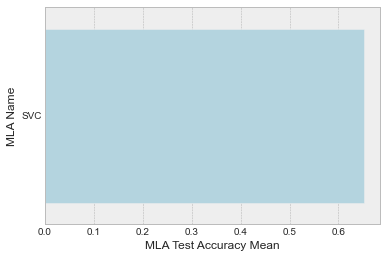

In [91]:
sns.barplot(x='MLA Test Accuracy Mean',y='MLA Name',data=MLA_compare,color='lightblue')

In [94]:
RF = ensemble.RandomForestClassifier()
base_results = model_selection.cross_validate(RF,data1_encoding[data_x],data1.PrefChannel,cv=cv_split)
RF.fit(data1_encoding[data_x],data1.PrefChannel)
print(RF.get_params())
print('BEFORE Test score mean:{:.2f}'.format(base_results['test_score'].mean()*100))
print('-'*10)
param_grid = {
    'n_estimators':[10,50,100,300],
    'criterion':['gini','entropy'],
    'max_depth':[2,4,6,8,10,None],
    'oob_score':[True],
    'random_state':[0]
}
tune_model = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),param_grid=param_grid,cv=cv_split)
tune_model.fit(data1_encoding[data_x],data1.PrefChannel)
print(tune_model.cv_results_.keys())
print(tune_model.best_params_)
print('AFTER Test Score Mean :{:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE Test score mean:59.93
----------
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_n_estimators', 'param_oob_score', 'param_random_state', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'oob_score': True, 'r

In [98]:
SVC = svm.SVC()
base_resutls=model_selection.cross_validate(SVC,data1_encoding[data_x],data1.PrefChannel,cv=cv_split)
SVC.fit(data1_encoding[data_x],data1.PrefChannel)
print(SVC.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [99]:
print('Test Score mean :{:.2f}'.format(base_results['test_score'].mean()*100))

Test Score mean :59.93


In [102]:
param_grid = {'C':[1,2,3,4,5],
              'decision_function_shape':['ovo','ovr']}
tune_model = model_selection.GridSearchCV(svm.SVC(),param_grid=param_grid)
tune_model.fit(data1_encoding[data_x],data1.PrefChannel)
print(tune_model.cv_results_.keys())
print(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_decision_function_shape', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
65.8679706601467


In [104]:
data_cluster_x = ['Age','MotorValue_fillmean']
data=data1[data_cluster_x]
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

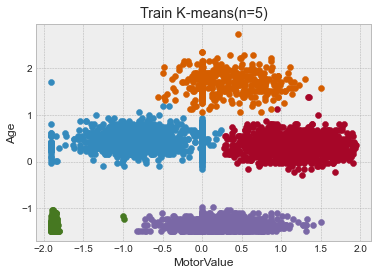

In [109]:
cluster_model = KMeans(n_clusters=5,random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
clusters_id = []
for cluster in clusters:
    row_ix = where(yhat==cluster)
    clusters_id.append(row_ix[0])
    plt.scatter(data[row_ix,1],data[row_ix,0])
plt.title('Train K-means(n=5)')
plt.xlabel('MotorValue')
plt.ylabel('Age')
plt.show()

In [112]:
print(metrics.calinski_harabasz_score(data,yhat))
print(silhouette_score(data,yhat))
from sklearn.metrics import silhouette_score
score = silhouette_score(data, yhat)
score

9556.82512064758
0.6703891682909885


0.6703891682909885

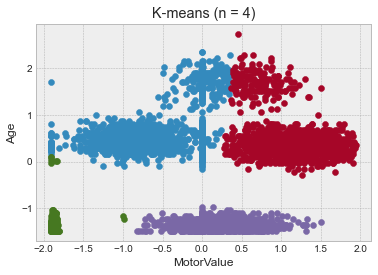

6254.257337859309


0.605027003705533

In [114]:
cluster_model = KMeans(n_clusters=4, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('K-means (n = 4)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print(metrics.calinski_harabasz_score(data, yhat))
cluster_model.cluster_centers_

from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score

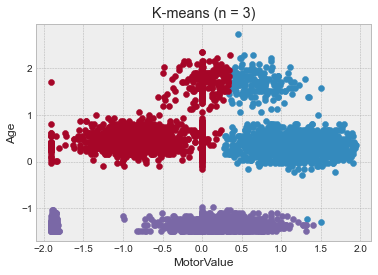

4508.865131669015


0.5205642805288917

In [115]:
cluster_model = KMeans(n_clusters=3, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('K-means (n = 3)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print(metrics.calinski_harabasz_score(data, yhat))
cluster_model.cluster_centers_

from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score


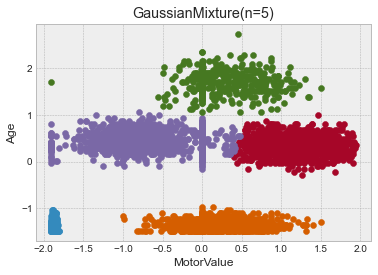

In [117]:
cluster_model=GaussianMixture(n_components=5,random_state=0)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat==cluster)
    plt.scatter(data[row_ix,1],data[row_ix,0])
plt.title('GaussianMixture(n=5)')
plt.xlabel('MotorValue')
plt.ylabel('Age')
plt.show()

In [119]:
data_cluster_x =['Age','MotorValue_fillmean']
data = data1[data_cluster_x]
scaler = StandardScaler()
scaler.fit(data)

data = scaler.transform(data)
data = pd.DataFrame(data)
data

0     1
0    -1.18  0.00
1     0.17  0.00
2    -1.44 -1.88
3     0.36 -0.83
4     0.81 -0.87
...    ...   ...
4085  1.71  0.00
4086  0.24  1.40
4087  0.43 -0.91
4088  0.36  0.45
4089  0.36  1.32

[4090 rows x 2 columns]

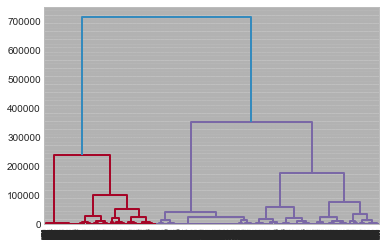

In [121]:
data_cluster_x = ['Age','MotorValue_fillmean']
data = data1[data_cluster_x]
Z = linkage(data,method='ward',metric='euclidean')
P = dendrogram(Z,0)

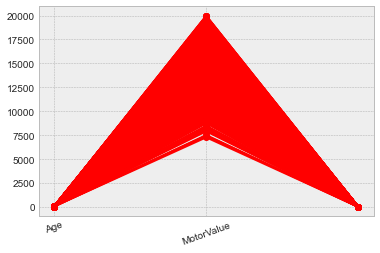

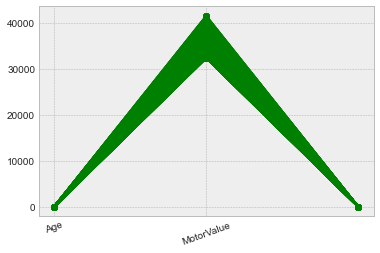

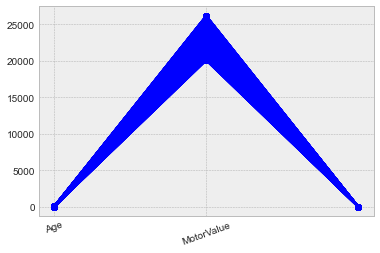

In [135]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5,linkage='ward')
model.fit(data)
r = pd.concat([data,pd.Series(model.labels_,index=data.index)],axis=1)
r.columns = list(data.columns)+['聚类类别']
style=['ro-','go-','bo-']
xlabels = ['Age','MotorValue']
for i in range(3):
    plt.figure()
    tmp = r[r[u'聚类类别']==i].iloc[:,:4]
    for j in range(len(tmp)):
        plt.plot(range(1,4),tmp.iloc[j],style[i])
    plt.xticks(range(1,3),xlabels,rotation=20)
    plt.subplots_adjust(bottom=0.15)

In [139]:
data_cluster_x = ['Age','MotorValue_fillmean']
data = data_score[data_cluster_x]
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)


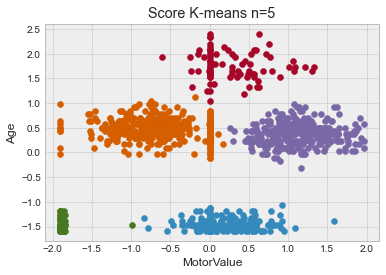

In [141]:
cluster_model = KMeans(n_clusters=5,random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
clusters_id =[]
for cluster in clusters:
    row_ix = where(yhat==cluster)
    clusters_id.append(row_ix[0])
    plt.scatter(data[row_ix,1],data[row_ix,0])
plt.title('Score K-means n=5')
plt.xlabel('MotorValue')
plt.ylabel('Age')
plt.show()
